In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import segmentation_models_pytorch as smp


In [ ]:
class ModalToAmodalDataset(Dataset):
    def __init__(self, sample_dir):
        self.sample_dir = Path(sample_dir)
        self.sample_dict = self.get_sample_dict(self.sample_dir)
        self.cameras = sorted([p.name for p in self.sample_dir.glob("camera_*")])
        self.obj_ids = [x for x in self.sample_dict[self.cameras[0]] if 'obj_' in x]
        self.num_frames = 24

    def get_sample_dict(self, sample_dir):
        def get_img_dict(img_dir):
            img_files = list(img_dir.glob("*.png")) + list(img_dir.glob("*.tiff"))
            img_files.sort()
            img_dict = {}
            for f in img_files:
                key = f.name.split('_')[0]
                img_dict.setdefault(key, []).append(f)
            return img_dict

        sample_dict = {}
        for cam_dir in sorted(sample_dir.glob("camera_*")):
            cam_dict = {'scene': get_img_dict(cam_dir)}
            for obj_dir in sorted(cam_dir.glob("obj_*")):
                cam_dict[obj_dir.name] = get_img_dict(obj_dir)
            sample_dict[cam_dir.name] = cam_dict
        return sample_dict

    def __len__(self):
        return len(self.obj_ids) * self.num_frames * len(self.cameras)

    def __getitem__(self, idx):
        cam_idx = idx // (len(self.obj_ids) * self.num_frames)
        cam_name = self.cameras[cam_idx % len(self.cameras)]
        obj_idx = (idx // self.num_frames) % len(self.obj_ids)
        frame_idx = idx % self.num_frames
        obj_id = self.obj_ids[obj_idx]

        scene_rgb_path = self.sample_dict[cam_name]['scene']['rgba'][frame_idx]
        modal_mask_path = self.sample_dict[cam_name]['scene']['segmentation'][frame_idx]
        amodal_mask_path = self.sample_dict[cam_name][obj_id]['segmentation'][frame_idx]

        rgb = ToTensor()(Image.open(scene_rgb_path).convert('RGB'))
        modal_mask_np = np.array(Image.open(modal_mask_path))
        obj_int = int(obj_id.split('_')[1])
        modal_mask = torch.tensor((modal_mask_np == obj_int).astype(np.float32)).unsqueeze(0)

        amodal_mask_np = np.array(Image.open(amodal_mask_path).convert('L')) / 255.0
        amodal_mask = torch.tensor(amodal_mask_np, dtype=torch.float32).unsqueeze(0)

        input_tensor = torch.cat((rgb, modal_mask), dim=0)
        return input_tensor, amodal_mask


In [ ]:
class OcclusionOnlyDataset(ModalToAmodalDataset):
    def __getitem__(self, idx):
        input_tensor, amodal = super().__getitem__(idx)
        modal = input_tensor[3]
        if torch.allclose(modal, amodal[0], atol=0.01):
            return self.__getitem__((idx + 1) % len(self))
        return input_tensor, amodal


In [ ]:
sample_dir = "ff5da6d6ecae486bb294aeaf5ee8f8a1"
dataset = OcclusionOnlyDataset(sample_dir)

# Split dataset: 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [ ]:
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights=None,
    in_channels=4,
    classes=1,
    activation='sigmoid'
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()


In [ ]:
model.train()
for epoch in range(3):
    total_loss = 0
    for inputs, targets in train_loader:
        preds = model(inputs)
        loss = loss_fn(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")


Epoch 1 | Loss: 27.0711
Epoch 2 | Loss: 12.0030
Epoch 3 | Loss: 10.3573


In [ ]:
model.eval()
test_loss = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        preds = model(inputs)
        loss = loss_fn(preds, targets)
        test_loss += loss.item()
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 3.0921


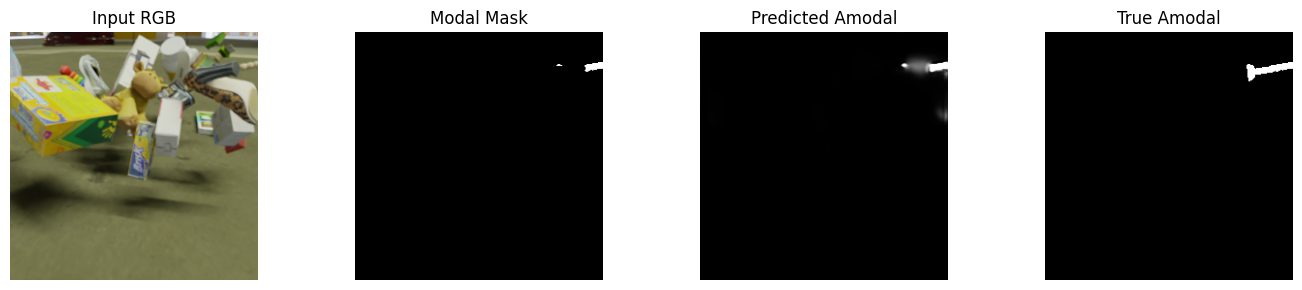

In [ ]:
x, y_true = test_dataset[5]

with torch.no_grad():
    y_pred = model(x.unsqueeze(0)).squeeze(0)

fig, axs = plt.subplots(1, 4, figsize=(14, 3))

axs[0].imshow(x[:3].permute(1, 2, 0))
axs[0].set_title("Input RGB")
axs[0].axis("off")

axs[1].imshow(x[3], cmap='gray')
axs[1].set_title("Modal Mask")
axs[1].axis("off")

axs[2].imshow(y_pred[0], cmap='gray')
axs[2].set_title("Predicted Amodal")
axs[2].axis("off")

axs[3].imshow(y_true[0], cmap='gray')
axs[3].set_title("True Amodal")
axs[3].axis("off")

plt.tight_layout()
plt.show()
